In [672]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
import datetime
import os
import csv
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

np.set_printoptions(linewidth=np.inf)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [673]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
logsFolder = "4-logs"

inputPretestFolder = inputFolder + r"\1-pretest"
inputPosttestFolder = inputFolder + r"\2-posttest"

dataVisualizationTopLimit = 20

testSize = 0.25
genericRandomState = 0
splitRandomState = 0
samplingStrategy = 0.2
percentileNumberStd = 90
percentileNumberCorrelation = 90

splitsNumber = 12

In [674]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8', header=True):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, header=header, index=False)

def parseTranspose(df):
  transposedDf = df.transpose()
  transposedDf = transposedDf.reset_index()
  transposedDf.columns = transposedDf.iloc[0]
  transposedDf = transposedDf[1:]

  return transposedDf

In [675]:
def showDescriptiveTables(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()
  
  descriptiveMeasuresDf = pd.DataFrame({
    "Nombre": ["PreTest_{}".format(indicator.capitalize()), "PostTest_{}".format(indicator.capitalize())],
    "Muestra": [ "{:.0f}".format(indicatorPreTestData.size), "{:.0f}".format(indicatorPostTestData.size) ],
    "Mínimo": [ "{:.4f}".format(indicatorPreTestData.min()), "{:.4f}".format(indicatorPostTestData.min()) ],
    "Máximo": [ "{:.4f}".format(indicatorPreTestData.max()), "{:.4f}".format(indicatorPostTestData.max()) ],
    "Media": [ "{:.4f}".format(indicatorPreTestData.mean()), "{:.4f}".format(indicatorPostTestData.mean()) ],
    "Desviación estándar": [ "{:.4f}".format(indicatorPreTestData.std()), "{:.4f}".format(indicatorPostTestData.std()) ],
  })

  display(descriptiveMeasuresDf.style.hide_index())

In [676]:
def showMeanDifference(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()

  colors = ["#7CAFDE", "#7CAFDE"]
  classes = [ "PreTest", "PostTest"]
  values =  [ indicatorPreTestData.mean(), indicatorPostTestData.mean() ]
  graph = plt.bar(classes, values, color=colors)

  percentage = []
  for value in values:
    percentage.append(value)

  if indicator != "tiempo":
    for index, p in enumerate(graph):
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2, y+0.5*height, "{:.2%}".format(percentage[index]), ha='center', weight='bold')

    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.ylabel("Porcentaje")
  else:
    for index, p in enumerate(graph):
      width = p.get_width()
      height = p.get_height()
      x, y = p.get_xy()
      plt.text(x+width/2, y+0.5*height, "{:.2f}s".format(percentage[index]), ha='center', weight='bold')

    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.0f}s".format(x)))
    plt.ylabel("Segundos")
  
  plt.title("Media de {}".format(indicator))
  plt.show()

In [677]:
def showNormalityTable(preTestDf, postTestDf, indicator):
  indicatorPreTestData, indicatorPostTestData = preTestDf[indicator].to_numpy(), postTestDf[indicator].to_numpy()

  preTestStatistic, preTestPValue = stats.shapiro(indicatorPreTestData)
  postTestStatistic, postTestPValue = stats.shapiro(indicatorPostTestData)
  
  descriptiveMeasuresDf = pd.DataFrame({
    "Nombre": ["PreTest_{}".format(indicator.capitalize()), "PostTest_{}".format(indicator.capitalize())],
    "Estadístico": [ "{:.4f}".format(preTestStatistic), "{:.4f}".format(postTestStatistic) ],
    "Grados de libertad": [ "{:.0f}".format(indicatorPreTestData.size), "{:.0f}".format(indicatorPostTestData.size) ],
    "P Valor": [ "{:.4f}".format(preTestPValue), "{:.4f}".format(postTestPValue) ],
  })

  display(descriptiveMeasuresDf.style.hide_index())

In [678]:
def showHistogram(df, indicator):
  data = df[indicator].to_numpy()
  
  mu, std = stats.norm.fit(data) 

  plt.hist(data, bins=9, color="tab:blue", ec="black")

  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = stats.norm.pdf(x, mu, std)*(xmax - xmin)*5

  plt.plot(x, p, 'k')

  plt.show()

In [679]:
def hypothesisTesting(preTestDf, postTestDf, indicator):
  """print("{}".format(column))

  postTestValues = 

  showHistogram(postTestValues)

  _, preTestPValue = stats.shapiro(preTestValues)
  print("P valor del pretest: {:.4f} -> {} es normal ".format(preTestPValue, "Si" if preTestPValue > 0.05 else "No"))
  _, postTestPValue = stats.shapiro(postTestValues)
  print("P valor del posttest: {:.4f} -> {} es normal ".format(postTestPValue, "Si" if postTestPValue > 0.05 else "No"))
  if (preTestPValue > 0.05 and postTestPValue > 0.05):
    print("Ambas distribuciones son normales, se usará la prueba t student")
    _, comparePValue = stats.ttest_ind(preTestValues, postTestValues)
  else:
    print("Al menos una distribución es no normal, se usará la prueba de wilcoxon")
    _, comparePValue = stats.wilcoxon(preTestValues, postTestValues)
  print("P valor de la comparación: {:.4f} -> {} -> {}".format(comparePValue,
                                                                "Se rechaza H0" if comparePValue < 0.05 else "No se rechaza H0",
                                                                "Las medias son diferentes" if comparePValue < 0.05 else "Las medias son iguales"
                                                              ))"""

  print()

  # Tiempo promedio
  # Primer pvalue: 0.6839864253997803
  # Segundo pvalue: 0.03948163986206055

In [680]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))

  # Obteniendo data de pretest y postest
  preTestDf = readCsvAsDf(os.path.join(inputPretestFolder, 'result.csv'))
  postTestDf = readCsvAsDf(os.path.join(inputPosttestFolder, 'result.csv'))

  # Definiendo los indicadores
  #indicators = ["exactitud", "precision", "sensibilidad", "robustez", "tiempo"]
  indicators = ["exactitud"]

  # Iterando por cada indicador
  for indicator in indicators:
    showDescriptiveTables(preTestDf, postTestDf, indicator)

    showMeanDifference(preTestDf, postTestDf, indicator)

    showNormalityTable(preTestDf, postTestDf, indicator)

    showHistogram(preTestDf, indicator)

    showHistogram(postTestDf, indicator)

    #hypothesisTesting(preTestDf, postTestDf, indicator)
    pass

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-07-07 02:15:56.092018


Nombre,Muestra,Mínimo,Máximo,Media,Desviación estándar
PreTest_Exactitud,48,0.8486,0.9971,0.9234,0.0500
PostTest_Exactitud,48,0.9930,0.9994,0.9963,0.0017


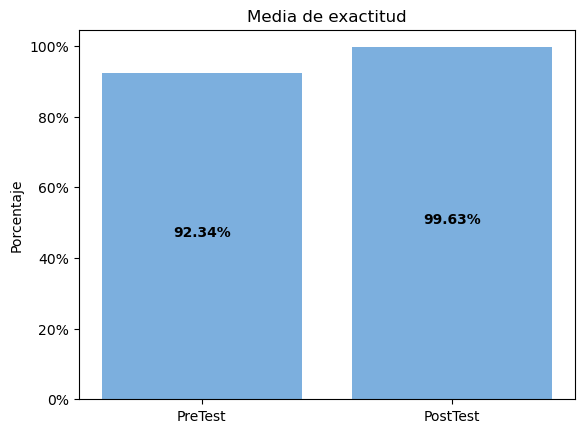

Nombre,Estadístico,Grados de libertad,P Valor
PreTest_Exactitud,0.9027,48,0.0008
PostTest_Exactitud,0.9540,48,0.0581


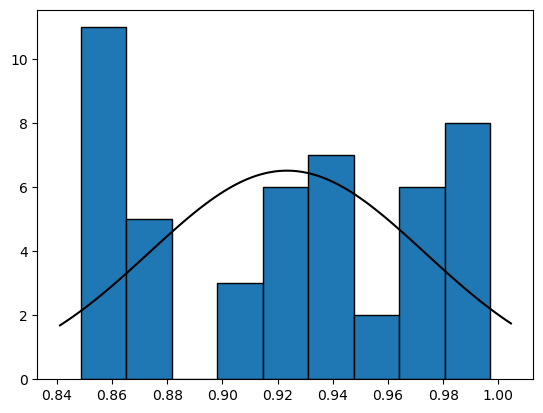

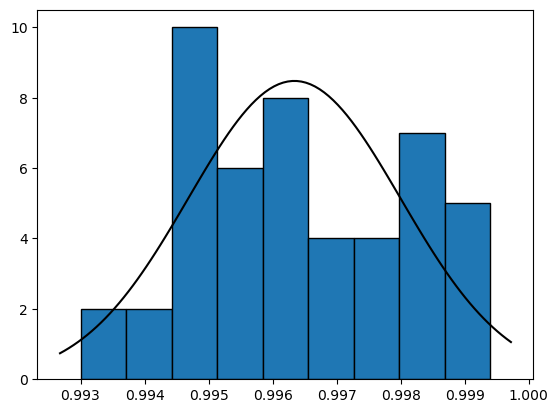

Fin: 2023-07-07 02:15:56.345996
Tiempo: 0:00:00.253978


In [681]:
if __name__ == "__main__":
  main()